# `Installation et importation des packages python`

In [1]:
! pip install -q keras

In [2]:
from glob import glob
import tarfile
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from tensorflow import keras

# Extraction des images de chien

In [3]:
base_dir = 'Images'
if(os.path.exists(base_dir)): shutil.rmtree(base_dir)
for file in glob("images.tar*"):
    os.remove(file)
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar --no-check-certificate

my_tar = tarfile.open('images.tar')
my_tar.extractall()
my_tar.close()

--2021-03-12 14:20:51--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  97.7MB/s    in 11s     

2021-03-12 14:21:02 (70.2 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [4]:
# selection de 10 images du dossier Images
os.listdir(f'{base_dir}/n02085620-Chihuahua')[:10]

['n02085620_1916.jpg',
 'n02085620_7700.jpg',
 'n02085620_3485.jpg',
 'n02085620_2706.jpg',
 'n02085620_575.jpg',
 'n02085620_4159.jpg',
 'n02085620_2590.jpg',
 'n02085620_8585.jpg',
 'n02085620_382.jpg',
 'n02085620_1346.jpg']

# Séparation du jeu de données

In [5]:
valid_dir = 'valid'
train_dir = 'train'

if(os.path.exists(train_dir)): shutil.rmtree(train_dir)
if(os.path.exists(valid_dir)): shutil.rmtree(valid_dir)

os.mkdir(valid_dir)
os.mkdir(train_dir)

for d in os.listdir(base_dir):
    dogs = os.listdir(f"{base_dir}/{d}")
    valid_len = int(len(dogs) * 0.3)
    train_len = len(dogs) - valid_len

    os.mkdir(f"{valid_dir}/{d}")
    os.mkdir(f"{train_dir}/{d}")

    for dog in dogs[:valid_len]:
        shutil.copy(f'{base_dir}/{d}/{dog}', f'{valid_dir}/{d}/{dog}')

    for dog in dogs[valid_len:len(dogs)]:  # [pointdepart: nombrediteration]
        shutil.copy(f'{base_dir}/{d}/{dog}', f'{train_dir}/{d}/{dog}')

# Etude du jeu de données

In [26]:
# on check la proportion d'images entre train et validimport sys
breeds = os.listdir(base_dir)

train_data = []
valid_data = []
total_data = []

for breed in breeds: 
  train_data += os.listdir(f'{train_dir}/{breed}')
  valid_data += os.listdir(f'{valid_dir}/{breed}')
  total_data += os.listdir(f'{base_dir}/{breed}')

print('total training dog images:', len(train_data))
print('total validating dog images:', len(valid_data))
print('total:', len(train_data) + len(valid_data))
print('nombre d\'images à l\'origine:', len(total_data))

total training dog images: 14458
total validating dog images: 6122
total: 20580
nombre d'images à l'origine: 20580


In [27]:
train_df = pd.DataFrame.from_dict(
    [{ 
        "breed": breed, 
        "count": len(os.listdir(f'{train_dir}/{breed}'))
    } for breed in breeds]
)
train_df

,breed,count
0,n02108000-EntleBucher,142
1,n02096437-Dandie_Dinmont,126
2,n02092339-Weimaraner,112
3,n02097047-miniature_schnauzer,108
4,n02110806-basenji,147
...,...,...
115,n02097209-standard_schnauzer,109
116,n02108422-bull_mastiff,110
117,n02097130-giant_schnauzer,110
118,n02102318-cocker_spaniel,112


In [28]:
valid_df = pd.DataFrame.from_dict(
    [{ 
        "breed": breed, 
        "count": len(os.listdir(f'{valid_dir}/{breed}'))
    } for breed in breeds]
)
valid_df

,breed,count
0,n02108000-EntleBucher,60
1,n02096437-Dandie_Dinmont,54
2,n02092339-Weimaraner,48
3,n02097047-miniature_schnauzer,46
4,n02110806-basenji,62
...,...,...
115,n02097209-standard_schnauzer,46
116,n02108422-bull_mastiff,46
117,n02097130-giant_schnauzer,47
118,n02102318-cocker_spaniel,47


In [29]:
valid_df.breed.values.tolist()[:10]

['n02108000-EntleBucher',
 'n02096437-Dandie_Dinmont',
 'n02092339-Weimaraner',
 'n02097047-miniature_schnauzer',
 'n02110806-basenji',
 'n02096585-Boston_bull',
 'n02106382-Bouvier_des_Flandres',
 'n02100735-English_setter',
 'n02095889-Sealyham_terrier',
 'n02113978-Mexican_hairless']

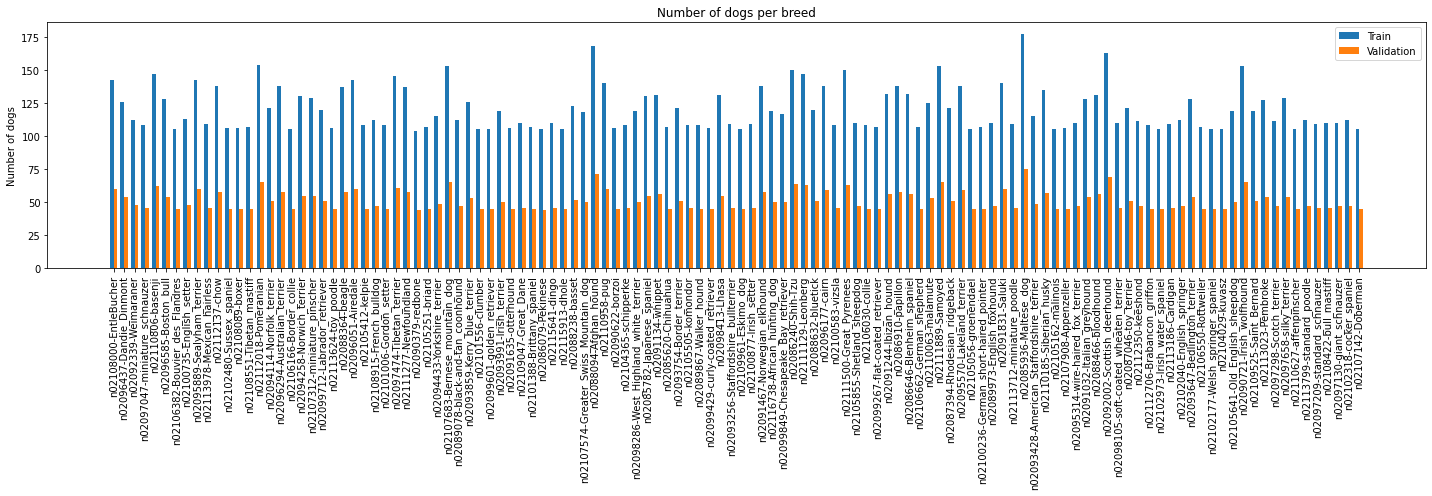

In [30]:
fig, ax = plt.subplots(figsize=(20, 7))
x = np.arange(len(train_df['breed'].values))

width = 0.35
rects1 = ax.bar(x - width/2, train_df['count'].values, width, label='Train')
rects2 = ax.bar(x + width/2, valid_df['count'].values, width, label='Validation')

ax.set_ylabel('Number of dogs')
ax.set_title('Number of dogs per breed')
ax.set_xticks(x)
ax.set_xticklabels(train_df['breed'].values, rotation='vertical')
ax.legend()

fig.tight_layout()
plt.show()

# Construction du Modèle CNN

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

def create_model(use_dropout :bool = False):
  # Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
  # the three color channels: R, G, and B
  img_input = layers.Input(shape=(150, 150, 3))

  # First convolution extracts 16 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(16, 3, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)

  # Second convolution extracts 32 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)

  # Third convolution extracts 64 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  x = layers.Conv2D(64, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)

  # Flatten feature map to a 1-dim tensor so we can add fully connected layers
  x = layers.Flatten()(x)

  # Create a fully connected layer with ReLU activation and 512 hidden units
  x = layers.Dense(512, activation='relu')(x)

  if use_dropout:
      x = layers.Dropout(0.5)(x)

  # Create output layer
  output = layers.Dense(120, activation='softmax')(x) # species number

  # Create model:
  # input = input feature map
  # output = input feature map + stacked convolution/maxpooling layers + fully 
  # connected layer + sigmoid output layer

  if 'model' in locals():
      del model 

  model_intra = Model(img_input, output)

  model_intra.summary()

  model_intra.compile(
      loss='categorical_crossentropy',
      optimizer=RMSprop(lr=0.001),
      metrics=['acc']
  )
  return model_intra

In [ ]:
model = create_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

## Sans data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_model(
    train_img_nb :int, 
    valid_img_nb :int, 
    batch_size :int,
    epochs :int, 
    use_data_augmentation :bool = False,
    use_early_stopping :bool = False,
    use_reduce_lr :bool = False,
):
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    ) if use_data_augmentation else ImageDataGenerator(
        rescale=1./255
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Flow training images using train_datagen generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=batch_size,
        classes=breeds
    )

    # Flow validation images in batches of 20 using val_datagen generator
    valid_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        classes=breeds
    )
    print(model.evaluate(valid_generator))

    callbacks = []
    if use_early_stopping:
        callbacks.append(EarlyStopping(
            patience=3, 
            verbose=1, 
            restore_best_weights=True
        ))
    if use_reduce_lr: 
        callbacks.append(ReduceLROnPlateau(
            factor=0.1, 
            patience=3, 
            verbose=1
        ))

    history = model.fit(
        train_generator,
        steps_per_epoch=int(train_img_nb / batch_size),
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=int(valid_img_nb / batch_size),
        verbose=2,
        callbacks=callbacks
    )
    return history

In [ ]:
history = train_model(
    len(train_data), 
    len(valid_data), 
    batch_size=20,
    epochs=3
)

Found 14458 images belonging to 120 classes.
Found 6122 images belonging to 120 classes.
307/307 [==============================] - 20s 67ms/step - loss: 5.8144 - acc: 0.0874
[5.8143815994262695, 0.0873897448182106]
Epoch 1/3
722/722 - 65s - loss: 1.1166 - acc: 0.7188 - val_loss: 6.3866 - val_acc: 0.0931
Epoch 2/3
722/722 - 64s - loss: 0.3050 - acc: 0.9229 - val_loss: 11.1067 - val_acc: 0.0770
Epoch 3/3
722/722 - 64s - loss: 0.1510 - acc: 0.9669 - val_loss: 12.3583 - val_acc: 0.0828


In [ ]:
def plot_history():
    # Retrieve a list of accuracy results on training and validation data
    # sets for each training epoch
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    # Get number of epochs
    epochs = range(len(acc))
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.show()

    # Retrieve a list of list results on training and validation data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Get number of epochs
    epochs = range(len(loss))
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.title('Training and validation loss')

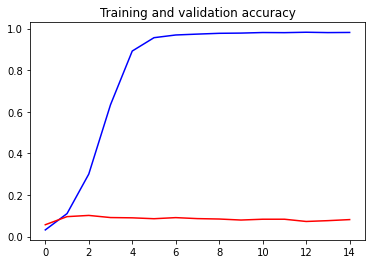

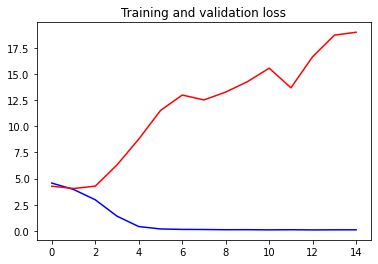

In [ ]:
plot_history()

Conclusion du loss il faut ajouter un dropout

## Avec data augmentation et dropout

In [ ]:
model = create_model(use_dropout=True)
history = train_model(
    len(train_data), 
    len(valid_data), 
    batch_size=25,
    epochs=20,
    use_data_augmentation=True
)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0   

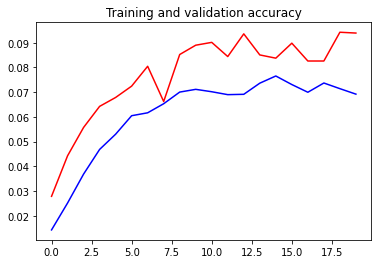

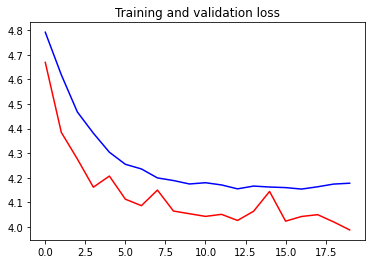

In [ ]:
plot_history()

In [ ]:
model.save("cnn_model.h5")

# Test

In [ ]:
! wget https://user.oc-static.com/upload/2019/02/23/15509395932064_image1.jpg

--2021-03-11 10:39:02--  https://user.oc-static.com/upload/2019/02/23/15509395932064_image1.jpg
Resolving user.oc-static.com (user.oc-static.com)... 172.67.169.198, 104.21.27.218, 2606:4700:3031::ac43:a9c6, ...
Connecting to user.oc-static.com (user.oc-static.com)|172.67.169.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52718 (51K) [image/jpeg]
Saving to: ‘15509395932064_image1.jpg’

15509395932064_imag 100%[===================>]  51.48K  --.-KB/s    in 0.01s   

2021-03-11 10:39:03 (3.85 MB/s) - ‘15509395932064_image1.jpg’ saved [52718/52718]



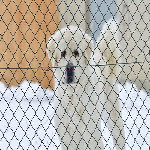

In [ ]:
img_test = keras.preprocessing.image.load_img('15509395932064_image1.jpg', target_size=(150,150))
img_test

Race du chien : great pyrenees (n02111500-Great_Pyrenees)

In [ ]:
predictions = model.predict((np.expand_dims(img_test,0)))
pd.DataFrame(predictions, columns=breeds).T.sort_values(by=0, ascending=False).round(2)

,0
n02110806-basenji,1.0
n02108000-EntleBucher,0.0
n02111129-Leonberg,0.0
n02086646-Blenheim_spaniel,0.0
n02088238-basset,0.0
...,...
n02105412-kelpie,0.0
n02111277-Newfoundland,0.0
n02098105-soft-coated_wheaten_terrier,0.0
n02091032-Italian_greyhound,0.0


Le résultat est mauvais.

Essai avec un basenji des images de validations, pour voir.

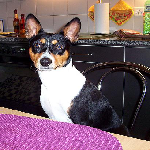

In [ ]:
img_test_2 = keras.preprocessing.image.load_img(f'{valid_dir}/n02110806-basenji/n02110806_1013.jpg', target_size=(150,150))
img_test_2

In [ ]:
predictions_2 = model.predict((np.expand_dims(img_test_2,0)))
pd.DataFrame(predictions_2, columns=breeds).T.sort_values(by=0, ascending=False)

,0
n02108000-EntleBucher,1.0
n02113023-Pembroke,0.0
n02091244-Ibizan_hound,0.0
n02105505-komondor,0.0
n02112137-chow,0.0
...,...
n02098105-soft-coated_wheaten_terrier,0.0
n02091032-Italian_greyhound,0.0
n02105056-groenendael,0.0
n02098413-Lhasa,0.0


Race attendu **basenji**, race obtenue **EntleBucher**.

Les oreilles et la silouhette ne sont pas bonnes mais les couleurs le sont.

## Test avec ReduceLROnPlateau + EarlyStopping

In [ ]:
model = create_model(use_dropout=True)
history = train_model(
    len(train_data), 
    len(valid_data), 
    batch_size=32,
    epochs=20,
    use_data_augmentation=True,
    use_early_stopping=True,
    use_reduce_lr=True,
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

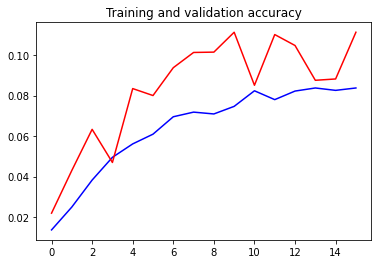

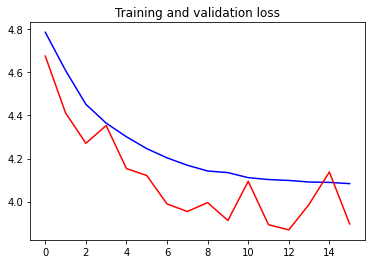

In [ ]:
plot_history()

In [ ]:
history